In [1]:
import os 
from datetime import datetime
import ubiops
from dotenv import load_dotenv

import matplotlib.pyplot as plt
from matplotlib import colormaps
import numpy as np
import xarray as xr
import utils


In [2]:
# Enter your API token here
load_dotenv(".env")

client = ubiops.ApiClient(ubiops.Configuration(
	host="https://api.ubiops.com/v2.1",
	api_key={"Authorization": os.environ["TOKEN_RAYCAST_USER"]})
)

api = ubiops.CoreApi(client)


In [3]:
# specify the reference datetime
ref_datetime = datetime.strptime("2024-06-20 09:00:00", "%Y-%m-%d %H:%M:%S")

# request
utils.raycast_data_by_query(token=os.environ["TOKEN_RAYCAST_USER"], ref_datetime=ref_datetime)
ds = xr.open_dataset(f"irradiance_{ref_datetime.strftime('%Y%m%dT%H%M%S')}.nc", engine="netcdf4")

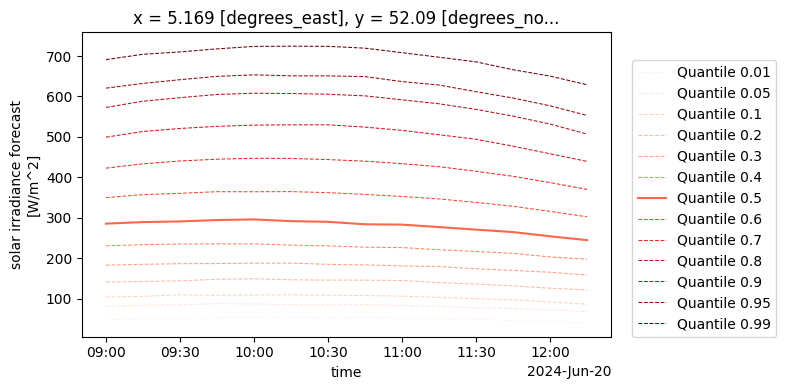

In [10]:
# specify location
x = 5.177       
y = 52.101

quantiles = [0.01, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 0.95, 0.99]


# figure 
fig, ax = plt.subplots(1,1,figsize=(8,4))
cmap = colormaps.get_cmap('Reds')
colors = [cmap(i) for i in np.linspace(0, 1, 13)] 

for i, q in enumerate(quantiles):
    if q == 0.5:
        ds.sel(x=x, y=y, quantile=q, method='nearest')['irradiance'].plot(ax=ax, color=colors[i], label=f"Quantile {q}", linewidth=1.5)
    else:
        ds.sel(x=x, y=y, quantile=q, method='nearest')['irradiance'].plot(ax=ax, color=colors[i], label=f"Quantile {q}", linewidth=0.75, linestyle='--')

plt.legend(loc=(1.04, 0))
plt.tight_layout()
